Article:
https://cseweb.ucsd.edu/~jmcauley/pdfs/www19.pdf

https://www.sciencetimes.com/articles/20642/20190423/new-personalized-deep-learning-tool-recommends-routes-by-estimating-runners-heart-rates.html

Data and instruction:
https://sites.google.com/eng.ucsd.edu/fitrec-project/home


The specific version of the data was cleaned: 
## Insights from the dataset and paper
 * Lots of workout sessions, and reasonable number of users
 * The average span for individual user is 733 days. Seems promising for a longitudinal study on how exercises change heart physiology.
 * During workout, individual's heart rate varies a lot. Factors include gender, workout type, speed, workout duration, and altitude elevation. Other implicit factors could be exercise frequency, how many days since starting of exercise, which can be extracted from the data. 
 * Unfortunately, age and body weight are important features missing in the dataset. However, on the feature engineering side, we can normalized first the data within individual user, and then examine the improvement of heart rate within individual user, compare those across different users, and how different factors influence the change of heart rate at the population level.
 * Build a model to predict long-term change of heart rate based on exercise statistics, and give personalized recommendation accordingly.
 * Tree model is probably the way to go, noted that the interaction between features are not trivial/linear. For example, figure 4: altitude influences the heart rate during biking differently from that during running
 
 <img src="stats.png" style="width:500px;height:600px;">

# Notes on the data:
### 'HR.csv': the Dataframe of workout with heart_rate recorded
    shape = (253020, 12)
* 'userId': unique user ID, there are total 1104 users. 
* 'gender': 'male' or 'female'
* 'id': unique id for each workout session
* 'sport': workout type
* 'ave_heart_rate': heart rate in beats per minute (bpm), averaged across the session
* 'ave_speed': averaged speed (Km/hour)
* 'ave_altitude': averaged altitude (meter)
* 'max_altitude': maximum altitude index, and maximum altitude (will be used to infer uphill or downhill)
* 'min_altitude': minimum altitdue index, and minimum altitude
* 'start_end': Start and end timestamps, in second
* 'ave_longitude', 'ave_latitude': averaged longitude and latitude

### 'Meta.csv': the metadata for all workout sessions
    shape = (962190, 12)
* 'userId': unique user ID, there are total 1364 users.
* 'hydration': ?
* 'gender': 'male' or 'female'
* 'id': unique id for each workout session
* 'sport': workout type
* 'ascent', 'descent': total ascent and descent in meters
* 'calories': total calories consumed
* 'distance': total distance in Km
* 'duration': session duration in second
* 'weather': there are 37 unique weather conditions, unknown
* 'start_time': workout starting time. 

## Example extracted features


| |UserID | Gender | Sport | Duration | Speed_mean | Speed_dev | Distance | Altitude_mean| Altitude_elevation_abs| Altitude_Dev | Longitude | Latitude| Heart_rate| Sessions_since_beginning |
|---:|:-------------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
| Session1 | 100 | male | bike | 3300 | | | | | | | | |||
| Session2 | 200 | female | running | 2700 | | | | | | ||| | |
| ... | ... | ... | ... | ... | | | | | | ||| | |

# Features Overview

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [86]:
df_meta = pd.read_csv('./data/Meta.csv')
print(df_meta.shape)
df_meta.drop(['Unnamed: 0','Unnamed: 0.1'], inplace = True, axis = 1)
df_meta.head()

(962190, 14)


,userId,hydration,sport,ascent,descent,calories,duration,id,distance,weather,gender,start_time
0,10014612,NaN,mountain bike,147.0,137.0,1313.0,3218.35,322483826,18.85551,7.0,male,2014-04-11T14:32:35.000Z
1,10014612,NaN,mountain bike,97.0,84.0,724.0,1728.33,322483840,10.91231,7.0,male,2014-04-10T14:56:01.000Z
2,10014612,NaN,mountain bike,82.0,94.0,424.0,1904.69,322483848,10.76309,6.0,male,2014-04-07T17:18:13.000Z
3,10014612,NaN,mountain bike,263.0,274.0,2732.0,7218.46,322483865,38.31579,1.0,male,2014-03-30T14:01:32.000Z
4,10014612,NaN,mountain bike,132.0,135.0,1301.0,3208.09,322483880,18.71360,1.0,male,2014-03-28T16:06:04.000Z


In [87]:
df_hr = pd.read_csv('./data/HR.csv')
print(df_hr.shape)
df_hr.drop(['Unnamed: 0'], inplace=True, axis=1)
df_hr.head()

(253020, 13)


,userId,gender,id,sport,ave_heart_rate,ave_speed,ave_altitude,max_altitude,min_altitude,start_end,ave_longitude,ave_latitude
0,10921915,male,396826535,bike,152.650,26.162158,43.0712,"[171, 74.2]","[468, 14.6]","[1408898746, 1408906335]",24.480066,60.182107
1,10921915,male,392337038,bike,147.710,27.218369,35.7248,"[255, 67.8]","[415, 17.2]","[1408221682, 1408226122]",24.546053,60.179142
2,10921915,male,389643739,bike,140.554,26.050774,62.4256,"[160, 94.0]","[461, 33.4]","[1407858459, 1407865208]",24.505033,60.174214
3,10921915,male,386729739,bike,147.020,26.877838,32.6104,"[246, 64.0]","[73, 12.4]","[1407432042, 1407436561]",24.544119,60.179844
4,10921915,male,383186560,bike (transport),167.154,NaN,22.7620,"[260, 37.8]","[355, 9.8]","[1406909434, 1406910791]",24.731128,60.178065


In [88]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962190 entries, 0 to 962189
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      962190 non-null  int64  
 1   hydration   281742 non-null  float64
 2   sport       962190 non-null  object 
 3   ascent      895838 non-null  float64
 4   descent     895792 non-null  float64
 5   calories    957149 non-null  float64
 6   duration    962182 non-null  float64
 7   id          962190 non-null  int64  
 8   distance    954784 non-null  float64
 9   weather     670266 non-null  float64
 10  gender      962190 non-null  object 
 11  start_time  962190 non-null  object 
dtypes: float64(7), int64(2), object(3)
memory usage: 88.1+ MB


In [89]:
df_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253020 entries, 0 to 253019
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   userId          253020 non-null  int64  
 1   gender          253020 non-null  object 
 2   id              253020 non-null  int64  
 3   sport           253020 non-null  object 
 4   ave_heart_rate  253020 non-null  float64
 5   ave_speed       49660 non-null   float64
 6   ave_altitude    253020 non-null  float64
 7   max_altitude    253020 non-null  object 
 8   min_altitude    253020 non-null  object 
 9   start_end       253020 non-null  object 
 10  ave_longitude   253020 non-null  float64
 11  ave_latitude    253020 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 23.2+ MB


In [90]:
# how many unique users in each dataset? how many users intersected in two datasets?
len(set(df_meta.userId)) , len(set(df_hr.userId)),len(set(df_meta.userId) & set(df_hr.userId))

(1364, 1104, 1104)

In [91]:
# how many unique workout session and shared ?
len(set(df_meta.id)) , len(set(df_hr.id)),  len(set(df_meta.id) & set(df_hr.id))

(962190, 253020, 253020)

In [92]:
df_meta.drop(['userId','sport','gender'],inplace=True, axis=1) # checked, all of them are identical
df = df_hr.merge(df_meta, on='id', how='left')
df.head()

,userId,gender,id,sport,ave_heart_rate,ave_speed,ave_altitude,max_altitude,min_altitude,start_end,ave_longitude,ave_latitude,hydration,ascent,descent,calories,duration,distance,weather,start_time
0,10921915,male,396826535,bike,152.650,26.162158,43.0712,"[171, 74.2]","[468, 14.6]","[1408898746, 1408906335]",24.480066,60.182107,NaN,423.0,428.0,1562.0,7587.375,53.88458,3.0,2014-08-24T09:45:46.000Z
1,10921915,male,392337038,bike,147.710,27.218369,35.7248,"[255, 67.8]","[415, 17.2]","[1408221682, 1408226122]",24.546053,60.179142,NaN,227.0,230.0,908.0,4439.025,32.60639,6.0,2014-08-16T13:41:22.000Z
2,10921915,male,389643739,bike,140.554,26.050774,62.4256,"[160, 94.0]","[461, 33.4]","[1407858459, 1407865208]",24.505033,60.174214,NaN,336.0,360.0,1138.0,6462.950,45.68974,3.0,2014-08-12T08:47:39.000Z
3,10921915,male,386729739,bike,147.020,26.877838,32.6104,"[246, 64.0]","[73, 12.4]","[1407432042, 1407436561]",24.544119,60.179844,NaN,245.0,241.0,921.0,4490.901,32.70480,NaN,2014-08-07T10:20:42.000Z
4,10921915,male,383186560,bike (transport),167.154,NaN,22.7620,"[260, 37.8]","[355, 9.8]","[1406909434, 1406910791]",24.731128,60.178065,NaN,90.0,108.0,350.0,1357.004,11.92104,3.0,2014-08-01T09:10:34.000Z


In [93]:
df.shape

(253020, 20)

In [94]:
df.gender.value_counts()

male       235119
female      15959
unknown      1942
Name: gender, dtype: int64

In [95]:
#distribution of sport types
df.sport.value_counts()

run                        117902
bike                        98001
mountain bike               13510
bike (transport)            10445
walk                         3831
indoor cycling               2606
core stability training      1262
orienteering                 1197
cross-country skiing          949
skate                         512
roller skiing                 408
fitness walking               402
hiking                        357
kayaking                      255
weight training               237
circuit training              218
gymnastics                    162
downhill skiing               144
rowing                        127
elliptical                     83
soccer                         71
treadmill running              70
aerobics                       46
swimming                       41
snowshoeing                    32
yoga                           22
badminton                      17
horseback riding               16
basketball                     14
stair climing 

In [96]:
#distribution of users' exercise sessions.
df.userId.value_counts()

3714939     2905
1063624     2163
1520156     1832
10821441    1666
2915343     1577
            ... 
7629457        1
6879414        1
4915057        1
3334434        1
6725147        1
Name: userId, Length: 1104, dtype: int64

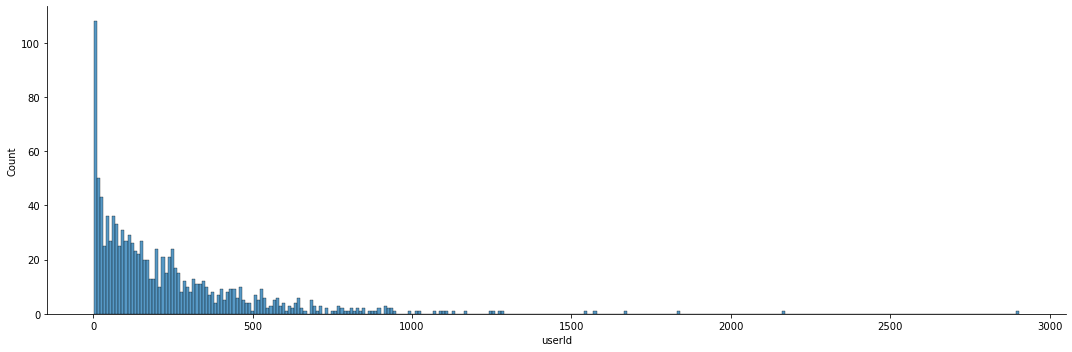

In [97]:
# distribution of number of sessions for each user
sns.displot(df.userId.value_counts(),kind = 'hist',bins=300, height=5, aspect=3);

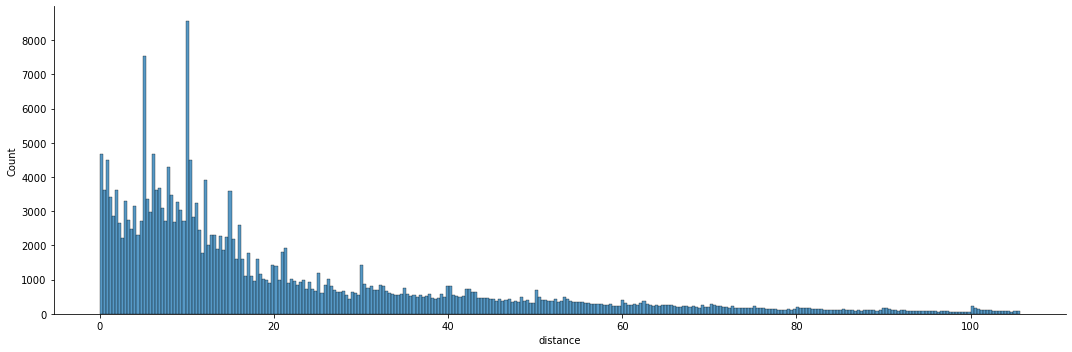

In [148]:
# distribution of number of sessions for each user
import numpy as np
def remove_outliers(df_list, whisker_lower=1.5, whisker_upper=3):
    '''
    reomve outliers
    return a pd.Series
    '''
    Q1 = df_list.quantile(0.25)
    Q3 = df_list.quantile(0.75)
    IQR = Q3 - Q1
    return df_list[(df_list >= (Q1 - whisker_lower * IQR)) & (df_list <= (Q3 + whisker_upper * IQR)) & (df_list >0) ]

def remove_outliers_inplace(df, columns, whisker_lower=1.5, whisker_upper=3,log_transform=False):
    '''
    remove outliers of each column in place, replace with NaN's
    columns = a list of strings, indicates column names
    '''
    for col in columns:
        df_list = df[col]
        Q1 = df_list.quantile(0.25)
        Q3 = df_list.quantile(0.75)
        IQR = Q3 - Q1
        df[col][~((df_list >= (Q1 - whisker_lower * IQR)) & (df_list <= (Q3 + whisker_upper * IQR)) & (df_list >0))] = None
        if log_transform:
            df[col] = df[col].map(lambda x: np.log(x+1.0) if x else None)
    return

df_distance = remove_outliers(df.distance)
sns.displot(df_distance, kind = 'hist',bins=300, height=5, aspect=3);

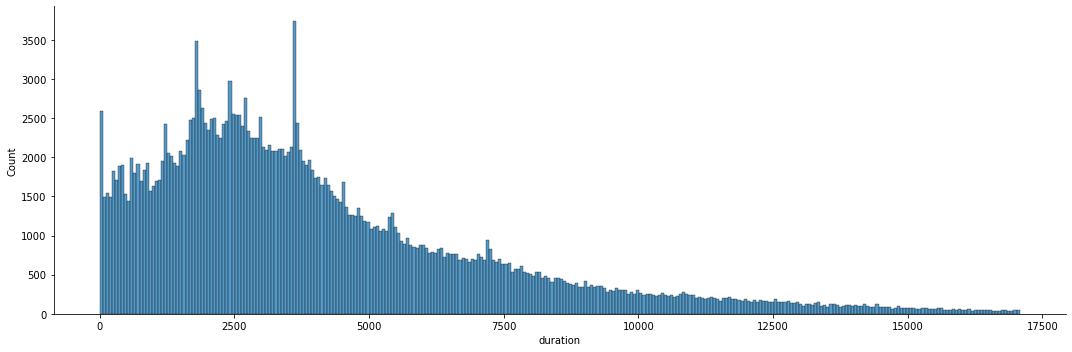

In [99]:
df_duration = remove_outliers(df.duration)
sns.displot(df_duration, kind = 'hist',bins=300, height=5, aspect=3);

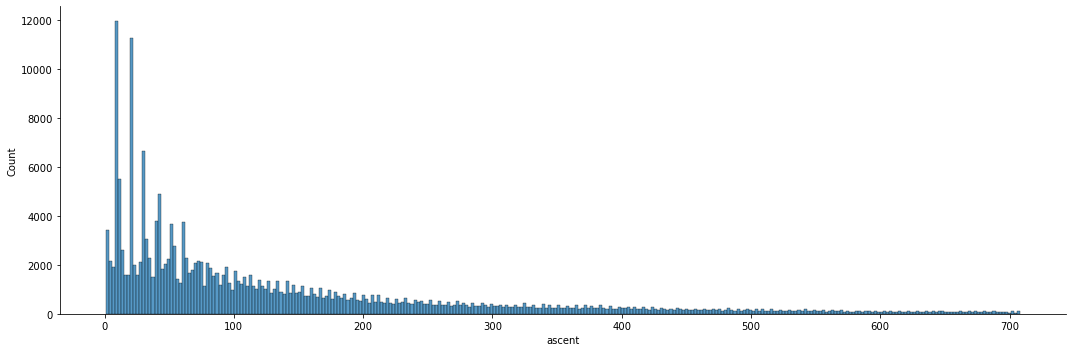

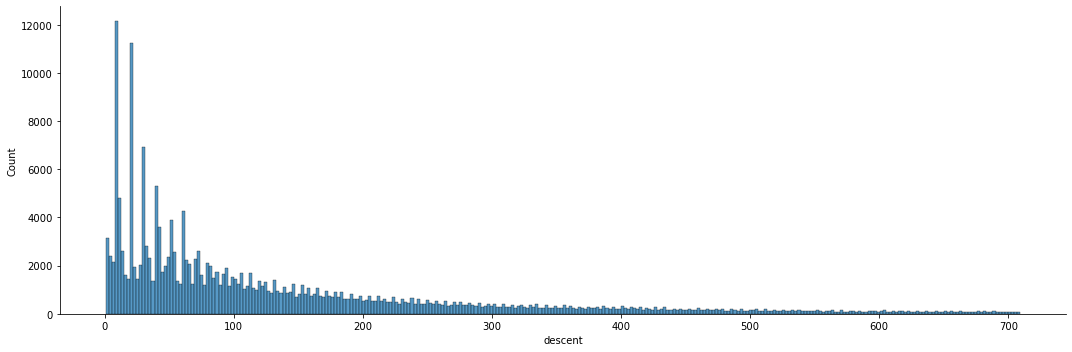

In [100]:
df_ascent = remove_outliers(df.ascent)
df_descent = remove_outliers(df.descent)
sns.displot(df_ascent, kind = 'hist',bins=300, height=5, aspect=3);
sns.displot(df_descent, kind = 'hist',bins=300, height=5, aspect=3);

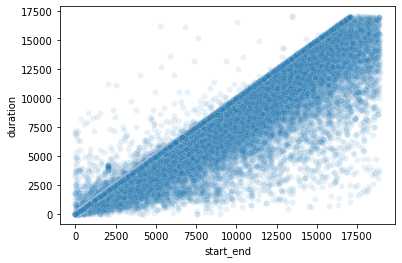

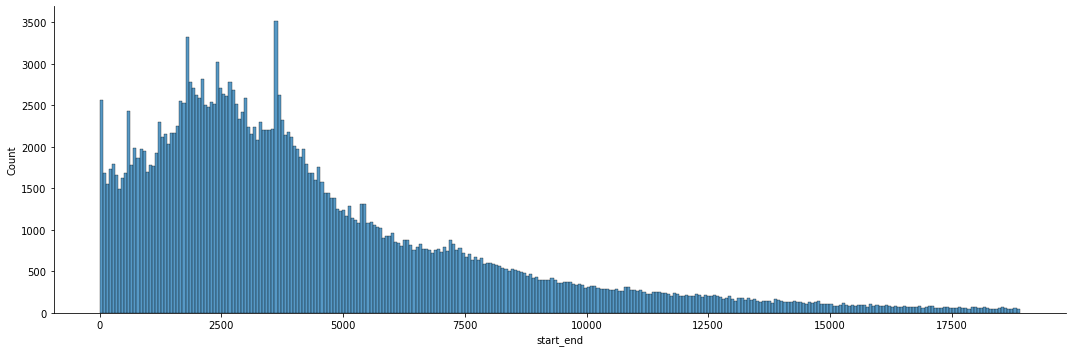

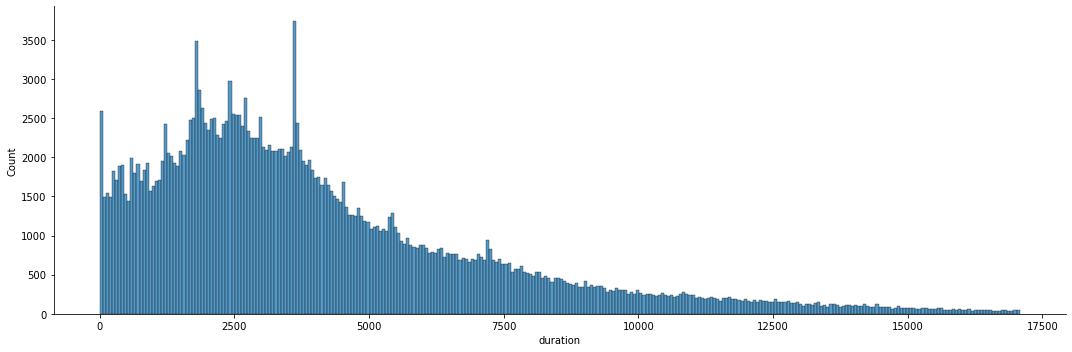

In [101]:
diff_start_end = df['start_end'].map(lambda x:eval(x)[1]-eval(x)[0])
diff_start_end  = remove_outliers(diff_start_end)
df_duration = remove_outliers(df.duration)

sns.scatterplot(x = diff_start_end, y=df_duration,alpha=0.1)
sns.displot(diff_start_end, kind = 'hist',bins=300, height=5, aspect=3);
sns.displot(df_duration, kind = 'hist',bins=300, height=5, aspect=3);

## gender difference of heart rate across different sport types

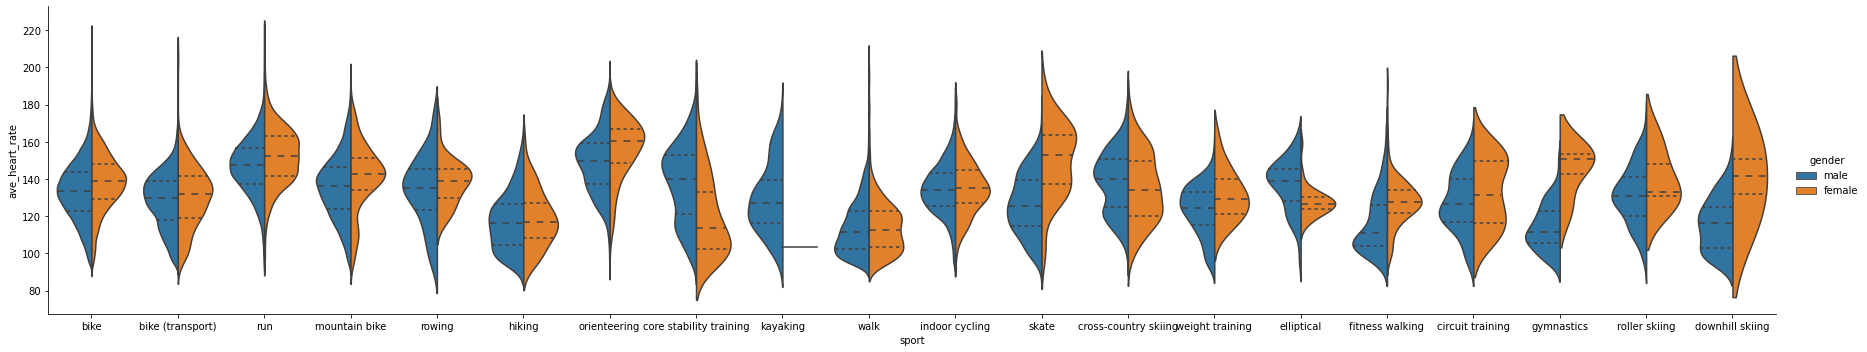

In [165]:
df.ave_heart_rate = remove_outliers(df.ave_heart_rate)
sport_top_20 = df.sport.value_counts().nlargest(20)

df_=df[df['sport'].isin(sport_top_20.index) & df['gender'].isin(['male','female'])]
sns.catplot(x="sport", y="ave_heart_rate", hue="gender", data=df_, kind="violin",  split=True, scale="width", inner="quart", aspect=5); #scale="count"

In [175]:
# relationship between duration vs calories, distance vs calories.
sport_top_2 = df.sport.value_counts().nlargest(2)
df_ = df[df['sport'].isin(sport_top_2.index) & df['gender'].isin(['male','female'])][['duration','distance','calories','sport','gender']]
remove_outliers_inplace(df_, ['duration','distance','calories'],log_transform = True)
df_ = df_[df_['calories'].notnull() & df_['duration'].notnull() & df_['distance'].notnull()]
print(df_.shape, round(len(df_)/len(df), 3))

(205476, 5) 0.812


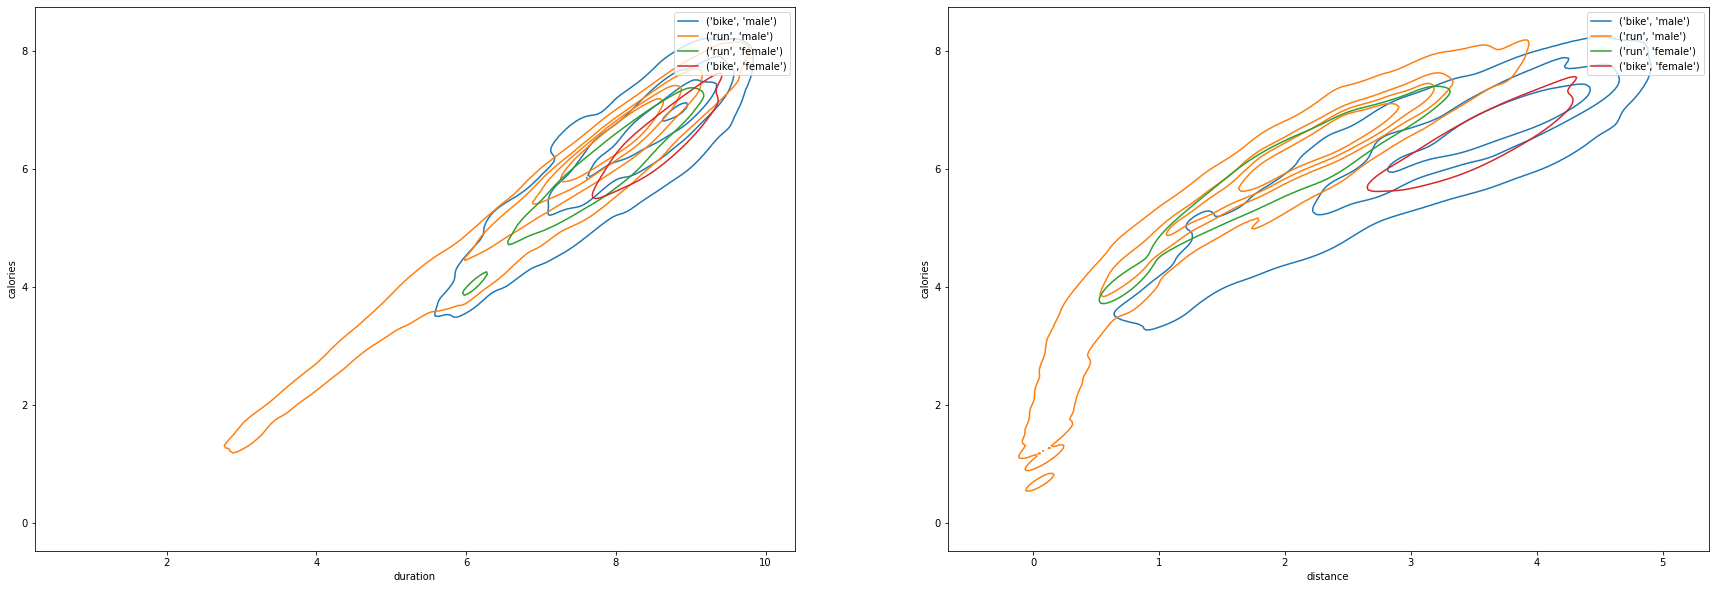

In [177]:
fig, axs = plt.subplots(1, 2, figsize=(30, 10))
hue = df_[['sport', 'gender']].apply(tuple, axis=1)
#sns.scatterplot(ax = axs[0], x='duration', y='calories', data = df_, hue='sport', marker=".", alpha = .3);
sns.kdeplot(ax = axs[0], x='duration', y='calories', data = df_, hue=hue,fill = False, levels=5);

#sns.scatterplot(ax = axs[1], x='distance', y='calories', data = df_, hue='sport', marker=".",alpha = .3);
sns.kdeplot(ax = axs[1], x='distance', y='calories', data = df_, hue=hue,fill = False, levels=5);

# tracking single user

In [ ]:
df_hr.info()

In [ ]:
df_hr.sport.value_counts()

In [ ]:
df_hr.gender.value_counts()

In [ ]:
df_hr.ave_longitude.mean()

In [ ]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

geometry = [Point(xy) for xy in zip(df_hr['ave_longitude'], df_hr['ave_latitude'])]
gdf = GeoDataFrame(df_hr[['ave_longitude','ave_latitude' ]], geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(color='white', edgecolor='blue', figsize=(25,15)), marker='.', color='red', markersize= 10, alpha = .1);
#plt.savefig('geo_density.png', dpi=300)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df_hr_ =df_hr[df_hr['sport'].isin(['bike','run']) & df_hr['gender'].isin(['male','female'])]
sns.catplot(x="sport", y="ave_heart_rate", hue="gender", data=df_hr_, kind="violin", scale="width", aspect=3);
plt.ylim(20, 250)

In [ ]:
df_hr_ = df_hr[df_hr['ave_speed'].notnull() & df_hr['sport'].isin(['run']) & df_hr['gender'].isin(['male','female']) ]
#df_hr_ = df_hr[df_hr['ave_speed'].notnull() & df_hr['sport'].isin(['bike','mountain bike','bike (transport)','indoor cycling']) & df_hr['gender'].isin(['male','female']) ]
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
sns.scatterplot(ax = axs[0], x='ave_speed',  y="ave_heart_rate", hue="gender", data=df_hr_, alpha = 0.1)
sns.kdeplot(ax = axs[1],x='ave_speed',  y="ave_heart_rate", hue="gender", data=df_hr_, fill = False, alpha = 0.5);
axs[0].set_xlim(0, 40),axs[1].set_xlim(0, 40)
axs[0].set_ylim(50, 220),axs[1].set_ylim(50, 220);

In [ ]:
df_hr_ = df_hr[df_hr['ave_altitude'].notnull() & df_hr['sport'].isin(['run']) & df_hr['gender'].isin(['male','female']) ]
fig, axs = plt.subplots(1, 2, figsize=(25, 5)) 
sns.scatterplot(ax = axs[0], x='ave_altitude',  y="ave_heart_rate", hue="gender", data=df_hr_, alpha = 0.1)
sns.kdeplot(ax = axs[1],x='ave_altitude',  y="ave_heart_rate", hue="gender", data=df_hr_, fill = False, alpha = 0.5);
#axs[0].set_xlim(0, 40),axs[1].set_xlim(0, 40)
axs[0].set_ylim(0, 250),axs[1].set_ylim(0, 250)

### 1. A simple RecSys without user data
* Data. Item features will be extracted from text (NLP required). 

| | Feature1(numeric) | Feature2(categorical)... | Descriptions (text) | Customer Reviews Ratings (numeric)| Customer Reviews (text)|
|---:|:-------------|:-----------|:-----------|:-----------|:-----------|
| Item1 | 100 | 'red'   | 'xxxxx'  | 1.0 | 'xxxxx'  | 
| Item2 | 200| 'blue'  | 'xxxxx'  | 4.0 | 'xxxxx'  | 
| Item3 | 200  | 'green'  | 'xxxxx'  | 4.5| 'xxxxx'  | 

* How does it work?
    * vectorize each item -> feature engineering with NLP tools
    * cluster items according to their features -> unsupervised learning methods such as Kmeans, DBSCAN, LDA or get a hierarchical structure
    * We can manually label few examples, and use semi-supervised learning methods for accurate clustering.
    * can also do keyword search. (a search engine)
         * vectorize the search keywords in a similar way as item descriptions
         * match the keyword vector with cluster averaged vector -> return the class tag of the clustering.-> a fuzzy search, from coarse to fine search use the hierarachical structures within the items.
         * match keyword vector with item vectors using similarity -> return individual item -> an itemwise search.
         * get the top K items according to similarity -> a ranking problem

### 2. A RecSys with content based filtering
* Data
    * Item information similar to in 1.
    * For user-item interaction, below is an example.
    * All we need is who interacted with what, we do not need detailed profile of customers.

| interaction index | User ID | Item ID | Interaction type/ratings (numeric, categorical) (optional)| Timestamp (optional) |
|---:|:-------------|:-----------|:-----------|:-----------|
| 0 | u1 |  v100 | 'view'  / 1.0 |  2022-6-20 13:56:00  | 
| 1 | u2 | v33  | 'purchase'  / 4.0 | 2022-6-20 13:56:01  | 
| 2 | u3  | v679  | 'comment'  / 4.5| 2022-6-20 13:56:59   | 

* Data processing: Convert the above user-interaction-item triplet into an interaction matrix $ X $
    * If the interaction type/ratings are specified, NaN means no interaction history, and graded value indicates strength of interaction, we will have a regression case.
    * If the interaction type/ratings are not specified, we will replace NaN with 0. use it as a binary classification case: 1 means interacted, 0 means not interacted.
    
| | item1 | item2 | item3 | item4 |
|---:|:-------------|:-----------|:-----------|:-----------|
| user0 | NaN |  1.0 | 3.0 | 0|
| user1 | 2.0 | 1.0  | 0 | 4.5|
| user2 | 0  | 2.5 | 5.0 | NaN |

* Content based filtering: How does it work?      
    * same as in section 1, we first vectorize each item
    * Let's say user A bought item x, recommend a similar item y such that a similarity score function sim(x,y) is highest. -> A recommendation/ranking problem
    * If the predicted A vs y relation is a rating score. Can we predict y accurately? -> A regression problem
    * If the predicted A vs y relation is binary -> classification problem
   

### 3. A RecSys with collaborative filtering 

* Collaborative filtering: how does it work?
    * Both user A and B purchased x, given user A also bought y, we should recommend y to B.
    * Concept is simple, implementation uses Matrix Factorization. The input is the interaction matrix X, the output is the two lower rank matrix U and V called factors

    * $X = U^T V$
         
         X has shape of (m,n) <br> 
         U has shape of (k,m)-> so called user embedding <br> 
         V has shape of (k,n)-> so called item embedding <br> 
         m is the number of users, n is the total number of items, k is the preset number of factors - "stereotypes" of user/item groups - usually k << m,n.
    * Loss function = MSE + L2 regularization
        $$ L(U,V) = \sum_{i,j}(u^T_i v_j - X_{i,j})^2+ \lambda (|u_i|^2 + |v_j|^2)$$
    * The graded rating can be used for regression. The binary value can be used for classification
    
    

### 4. User-attribute-aware collaborative filtering

* with item, user-item information
* Additional User attributes can refine the collaborative filtering further, but we will not go into the rabbit hole


| | Gender| Age | Geographic info (zipcode, IP etc)|
|---:|:-------------|:-----------|:-----------|
| User1 | F | 20   | 'xxxxx' |
| User2 | M | 40  | 'xxxxx'  | 
| User3 | M | 50  | 'xxxxx'  | 



## Problem statement
* Bussiness problems
* Metrics


## Data
* Items / Users / User-Item

## Model
* Feature selection
* Feature engineering
* how to train-val-test split
* 

## Deployment
* 